<a href="https://colab.research.google.com/github/lotrmay/TensorFlow_Learning/blob/master/bc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(14081, 98)
(4694, 98)
Epoch 1/1000
221/221 [==============================] - 1s 3ms/step - loss: 0.7082 - accuracy: 0.5417 - val_loss: 0.6958 - val_accuracy: 0.5215
Epoch 2/1000
221/221 [==============================] - 0s 2ms/step - loss: 0.6921 - accuracy: 0.5400 - val_loss: 0.6937 - val_accuracy: 0.5239
Epoch 3/1000
221/221 [==============================] - 0s 2ms/step - loss: 0.6912 - accuracy: 0.5359 - val_loss: 0.6921 - val_accuracy: 0.5254
Epoch 4/1000
221/221 [==============================] - 0s 2ms/step - loss: 0.6894 - accuracy: 0.5418 - val_loss: 0.6908 - val_accuracy: 0.5279
Epoch 5/1000
221/221 [==============================] - 0s 2ms/step - loss: 0.6885 - accuracy: 0.5423 - val_loss: 0.6892 - val_accuracy: 0.5320
Epoch 6/1000
221/221 [==============================] - 0s 2ms/step - loss: 0.6866 - accuracy: 0.5526 - val_loss: 0.6880 - val_accuracy: 0.5362
Epoch 7/1000
221/221 [==============================] - 0s 2ms/step - loss: 0.6862 - accuracy: 0.5459 - val_loss:

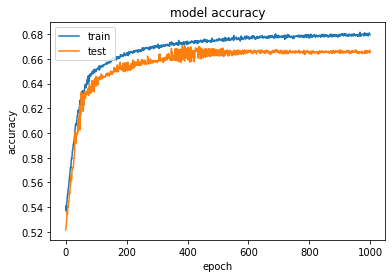

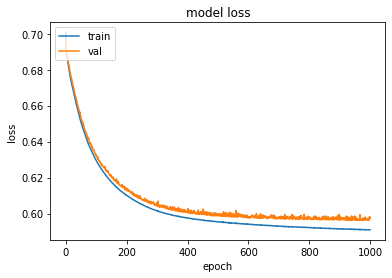

In [29]:
%tensorflow_version 2.x
import tensorflow as tf
from __future__ import absolute_import, division, print_function, unicode_literals
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import numpy as np #better arrays in python, lepší práce s multidimenzionálními poli
import pandas as pd #data analytics tool, lepší manipulace s daty, dokáže například cut outnout column
import matplotlib.pyplot as plt #vizualizace tabulek a grafů
from IPython.display import clear_output #jen pro tenhle notebook
from six.moves import urllib
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import utils as np_utils
import matplotlib.pyplot as plt
import numpy
import keras
CSV_COLUMN_NAMES=['Odds_firstTeam','Odds_secondTeam','Rank_firstTeam','Rank_secondTeam','WinRate_firstTeam','WinRate_secondTeam','PistolWinRate_firstTeam','PistolWinRate_secondTeam',
                  'playerAARating','playerAADpr','playerAAKast','playerAAImpact','playerAAAdr','playerAAKpr','playerAAHs','playerAAKD','playerAAGrenadeDmg',
                  'playerABRating','playerABDpr','playerABKast','playerABImpact','playerABAdr','playerABKpr','playerABHs','playerABKD','playerABGrenadeDmg',
                  'playerACRating','playerACDpr','playerACKast','playerACImpact','playerACAdr','playerACKpr','playerACHs','playerACKD','playerACGrenadeDmg',
                  'playerADRating','playerADDpr','playerADKast','playerADImpact','playerADAdr','playerADKpr','playerADHs','playerADKD','playerADGrenadeDmg',
                  'playerAERating','playerAEDpr','playerAEKast','playerAEImpact','playerAEAdr','playerAEKpr','playerAEHs','playerAEKD','playerAEGrenadeDmg',
                  'playerBARating','playerBADpr','playerBAKast','playerBAImpact','playerBAAdr','playerBAKpr','playerBAHs','playerBAKD','playerBAGrenadeDmg',
                  'playerBBRating','playerBBDpr','playerBBKast','playerBBImpact','playerBBAdr','playerBBKpr','playerBBHs','playerBBKD','playerBBGrenadeDmg',
                  'playerBCRating','playerBCDpr','playerBCKast','playerBCImpact','playerBCAdr','playerBCKpr','playerBCHs','playerBCKD','playerBCGrenadeDmg',
                  'playerBDRating','playerBDDpr','playerBDKast','playerBDImpact','playerBDAdr','playerBDKpr','playerBDHs','playerBDKD','playerBDGrenadeDmg',
                  'playerBERating','playerBEDpr','playerBEKast','playerBEImpact','playerBEAdr','playerBEKpr','playerBEHs','playerBEKD','playerBEGrenadeDmg','Match_link','Result','team_one_name','team_two_name']
RESULTS=['0','1']
CSV_COLUMN_NAMES_WITHOUT_STRINGS=['Odds_firstTeam','Odds_secondTeam','Rank_firstTeam','Rank_secondTeam','WinRate_firstTeam','WinRate_secondTeam','PistolWinRate_firstTeam','PistolWinRate_secondTeam',
                  'playerAARating','playerAADpr','playerAAKast','playerAAImpact','playerAAAdr','playerAAKpr','playerAAHs','playerAAKD','playerAAGrenadeDmg',
                  'playerABRating','playerABDpr','playerABKast','playerABImpact','playerABAdr','playerABKpr','playerABHs','playerABKD','playerABGrenadeDmg',
                  'playerACRating','playerACDpr','playerACKast','playerACImpact','playerACAdr','playerACKpr','playerACHs','playerACKD','playerACGrenadeDmg',
                  'playerADRating','playerADDpr','playerADKast','playerADImpact','playerADAdr','playerADKpr','playerADHs','playerADKD','playerADGrenadeDmg',
                  'playerAERating','playerAEDpr','playerAEKast','playerAEImpact','playerAEAdr','playerAEKpr','playerAEHs','playerAEKD','playerAEGrenadeDmg',
                  'playerBARating','playerBADpr','playerBAKast','playerBAImpact','playerBAAdr','playerBAKpr','playerBAHs','playerBAKD','playerBAGrenadeDmg',
                  'playerBBRating','playerBBDpr','playerBBKast','playerBBImpact','playerBBAdr','playerBBKpr','playerBBHs','playerBBKD','playerBBGrenadeDmg',
                  'playerBCRating','playerBCDpr','playerBCKast','playerBCImpact','playerBCAdr','playerBCKpr','playerBCHs','playerBCKD','playerBCGrenadeDmg',
                  'playerBDRating','playerBDDpr','playerBDKast','playerBDImpact','playerBDAdr','playerBDKpr','playerBDHs','playerBDKD','playerBDGrenadeDmg',
                  'playerBERating','playerBEDpr','playerBEKast','playerBEImpact','playerBEAdr','playerBEKpr','playerBEHs','playerBEKD','playerBEGrenadeDmg']



train=pd.read_csv('/content/pokus.csv',sep=";",names=CSV_COLUMN_NAMES,error_bad_lines=False,header=None)
#train_y=train.pop('Result')
#test_y=test.pop('Result')
train.pop('Match_link')
train.pop('team_one_name')
train.pop('team_two_name')
target_column = ['Result'] 
predictors = list(set(list(train.columns))-set(target_column))
scaler = MinMaxScaler(feature_range=(0.01, 0.99))
norm = StandardScaler()
train[predictors]=norm.fit_transform(train[predictors])
train[predictors] = scaler.fit_transform(train[predictors])


#train[predictors] = train[predictors]/train[predictors].max()

X = train[predictors].values
y = train[target_column].values
#print(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=35)
print(X_train.shape); print(X_test.shape)
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
count_classes = y_test.shape[1]


model = Sequential()
model.add(Dense(98, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(2, activation='softmax'))

# Compile the model
model.compile(optimizer=keras.optimizers.Adadelta(learning_rate=0.01), #keras.optimizers.SGD(learning_rate=0.01)
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

#adadelta 
#binary_crossentropy
#categorical_crossentropy
# categorical_hinge 0.677
# hinge 0.667
# MeanAbsoluteError 0.654, ale do 1500 epochs to bylo nad 0.67
# MeanAbsolutePercentageError 0.6814 nevyskytuje se snížení po 1500 epochs jako minule
history = model.fit(X_train, y_train, epochs=1000,batch_size=64,validation_data=(X_test, y_test))

pred_train= model.predict(X_train)
scores = model.evaluate(X_train, y_train, verbose=0)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   
 
pred_test= model.predict(X_test)



scores2 = model.evaluate(X_test, y_test, verbose=0)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [30]:
Xnew=np.array([[1.73,2.03,30,54,0.46,0.17,0.471,0.5,1.07,0.68,0.7,1.07,77.9,0.68,0.47,1.00,3.3,1.05,0.68,0.67,1.12,80.0,0.67,0.48,0.98,5.9,1.02,0.7,0.68,1.06,73.9,0.68,0.59,0.97,5.2,0.96,0.65,0.67,0.89,65.0,0.64,0.36,0.99,3.2,1.025,0.6775,0.68,1.0350000000000001,74.2,0.6675000000000001,0.475,0.9850000000000001,4.3999999999999995,1.1,0.72,0.72,1.07,83.8,0.73,0.51,1.01,7.7,1.03,0.75,0.65,1.26,78.6,0.7,0.52,0.94,4.5,0.94,0.69,0.69,0.91,64.9,0.6,0.35,0.88,3.6,0.93,0.68,0.72,0.78,65.5,0.56,0.52,0.82,3.8,0.9,0.72,0.68,0.86,65.0,0.57,0.57,0.79,3.7],
                [1.3,3.3,9,36,0.6,0.47,0.505,0.533,1.13,0.61,0.7,1.21,72.6,0.71,0.24,1.17,2.3,1.12,0.63,0.72,1.07,78.0,0.72,0.52,1.16,5.7,1.1,0.7,0.68,1.16,83.7,0.71,0.54,1.02,11.2,0.95,0.65,0.7,0.85,66.4,0.57,0.56,0.89,6.5,0.95,0.7,0.69,0.92,67.3,0.63,0.57,0.89,6.0,1.15,0.65,0.69,1.21,78.0,0.78,0.29,1.20,2.4,1.09,0.61,0.72,0.97,76.2,0.67,0.39,1.10,5.5,1.04,0.7,0.67,1.13,77.8,0.7,0.48,1.00,3.5,0.97,0.69,0.69,0.89,70.7,0.62,0.52,0.90,5.5,0.87,0.69,0.65,0.86,61.2,0.55,0.55,0.80,3.9],
                [2.56,1.44,100,83,0.53,0.44,0.5,0.5,1.23,0.57,0.75,1.25,73.9,0.77,0.36,1.35,3.6,1.19,0.65,0.7,1.29,84.4,0.74,0.54,1.15,6.0,1.09,0.71,0.7,1.06,78.6,0.73,0.53,1.03,4.7,1.06,0.66,0.72,1.08,73.3,0.65,0.51,0.97,4.7,0.96,0.63,0.69,0.81,66.8,0.57,0.43,0.90,3.7,1.17,0.62,0.73,1.24,80.0,0.81,0.23,1.31,1.3,1.08,0.69,0.68,1.22,78.2,0.76,0.55,1.10,3.5,1.0,0.74,0.67,1.22,79.3,0.66,0.46,0.88,4.5,0.95,0.71,0.71,0.94,71.8,0.63,0.56,0.89,3.8,0.85,0.69,0.67,0.73,66.9,0.54,0.38,0.78,4.4],
                [1.53,2.33,2,15,0.64,0.61,0.464,0.5,1.29,0.59,0.75,1.32,86.3,0.83,0.37,1.41,1.5,1.13,0.65,0.72,1.11,81.9,0.71,0.49,1.10,5.2,1.1,0.58,0.72,1.02,70.4,0.69,0.67,1.20,4.3,1.01,0.58,0.74,0.81,67.3,0.58,0.5,1.01,4.9,0.89,0.67,0.69,0.81,62.5,0.52,0.38,0.77,4.4,1.33,0.65,0.76,1.45,93.9,0.85,0.56,1.31,6.8,1.13,0.54,0.74,1.03,69.3,0.67,0.3,1.23,4.3,1.1,0.6,0.73,0.97,75.0,0.71,0.52,1.19,5.5,1.09,0.67,0.73,1.12,74.5,0.7,0.63,1.04,4.6,1.01,0.63,0.73,0.85,70.4,0.61,0.56,0.96,6.7],
                [2.9,1.38,55,17,0.62,0.67,0.493,0.479,1.29,0.55,0.78,1.29,81.0,0.8,0.24,1.44,5.7,1.13,0.64,0.69,1.19,78.3,0.74,0.5,1.16,7.4,1.1,0.64,0.75,1.08,72.6,0.68,0.64,1.06,4.6,1.05,0.63,0.74,0.93,71.4,0.65,0.52,1.03,5.3,0.97,0.66,0.72,0.83,67.8,0.56,0.53,0.86,6.4,1.1,0.66,0.71,1.12,77.9,0.69,0.52,1.04,5.3,1.09,0.64,0.72,1.06,76.4,0.69,0.54,1.08,4.3,1.06,0.63,0.74,0.94,73.1,0.64,0.38,1.02,6.7,1.04,0.65,0.71,1.01,69.8,0.67,0.43,1.03,3.2,1.0725000000000002,0.645,0.72,1.0325,74.3,0.6725,0.46749999999999997,1.0425,4.875],
               [2.15,1.65,47,52,0.53,0.39,0.523,0.543,1.11,0.63,0.72,1.08,74.3,0.72,0.27,1.14,5.3,1.05,0.74,0.67,1.23,78.7,0.71,0.45,0.97,5.6,1.01,0.68,0.7,0.94,74.0,0.66,0.44,0.96,6.4,0.97,0.65,0.71,0.81,65.3,0.63,0.53,0.96,3.6,0.96,0.71,0.67,0.98,74.0,0.6,0.47,0.84,8.2,1.15,0.63,0.71,1.19,76.0,0.74,0.28,1.19,3.3,1.04,0.68,0.71,0.98,74.5,0.67,0.49,0.98,4.2,1.03,0.69,0.71,1.03,74.3,0.65,0.46,0.95,6.6,0.93,0.71,0.64,0.99,69.8,0.59,0.46,0.84,5.7,0.86,0.65,0.67,0.68,60.1,0.54,0.55,0.83,2.9],
               [1.45,2.5,19,34,0.61,0.75,0.5,0.571,1.34,0.6,0.76,1.37,87.5,0.9,0.39,1.50,2.7,1.08,0.69,0.72,1.09,76.5,0.69,0.58,1.00,4.0,1.07,0.63,0.74,0.95,73.2,0.64,0.55,1.03,4.5,1.02,0.69,0.7,0.97,74.6,0.66,0.6,0.97,4.3,1.1275,0.6525,0.73,1.095,77.94999999999999,0.7225,0.53,1.125,3.875,1.37,0.59,0.77,1.44,87.2,0.89,0.33,1.50,2.5,1.27,0.58,0.78,1.19,83.8,0.78,0.55,1.36,5.4,1.18,0.64,0.72,1.17,82.2,0.77,0.47,1.21,4.5,1.12,0.59,0.75,1.01,72.9,0.66,0.47,1.13,4.1,1.06,0.66,0.71,1.06,73.5,0.65,0.55,0.99,4.7]
               ])
Xnew=norm.fit_transform(Xnew)
Xnew = scaler.fit_transform(Xnew)

ynew=(model.predict([Xnew]))
#ynew=(model.predict_classes([Xnew]))
print(ynew)

Consider rewriting this model with the Functional API.
[[0.21813457 0.7818655 ]
 [0.53288627 0.4671137 ]
 [0.08224434 0.91775566]
 [0.9392726  0.0607274 ]
 [0.05673881 0.94326127]
 [0.37697977 0.62302023]
 [0.03277234 0.9672277 ]]
